# Generate Hubert Codes and their CTC word segmentations for English Speech

(use conda env huggingface for this notebook)

# imports

In [251]:
import torch
from transformers import HubertForCTC, Wav2Vec2Processor
from datasets import load_dataset
import soundfile as sf
import librosa
from tqdm import tqdm
import os
import unicodedata
import re
from dataclasses import dataclass
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [20, 6]

# check cuda

In [252]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Set paths for writing outputs

In [253]:
outdir = "/home/s1785140/data/LJSpeech-1.1/hubert_CTC_word_segmentation"
# outdir_with_repeats = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_transcription_with_grapheme_repeats"
# outdir_raw_outputs = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_raw_outputs"

os.makedirs(outdir, exist_ok=True)
# os.makedirs(outdir_with_repeats, exist_ok=True)
# os.makedirs(outdir_raw_outputs, exist_ok=True)

# load pretrained model and text processor

In [254]:
processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(device)

### examine the labels for each output id of the processor.tokenizer

In [255]:
tokenizer_output_vocab = processor.tokenizer.get_vocab()
print("tokenizer_output_vocab")
tokenizer_output_vocab

tokenizer_output_vocab


{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 'E': 5,
 'T': 6,
 'A': 7,
 'O': 8,
 'N': 9,
 'I': 10,
 'H': 11,
 'S': 12,
 'R': 13,
 'D': 14,
 'L': 15,
 'U': 16,
 'M': 17,
 'W': 18,
 'C': 19,
 'F': 20,
 'G': 21,
 'Y': 22,
 'P': 23,
 'B': 24,
 'V': 25,
 'K': 26,
 "'": 27,
 'X': 28,
 'J': 29,
 'Q': 30,
 'Z': 31}

# Get wavs

In [256]:
wav_dir = "/home/s1785140/data/LJSpeech-1.1/audio_data/LJSpeech-1.1/wavs" # LJSpeech wavs no additional processing
wavs = os.listdir(wav_dir)
wav_paths = [os.path.join(wav_dir, wav) for wav in wavs]
print(len(wav_paths))

13100


# Get text transcripts for WAVS and further normalise out non-apostrophe punctuation and make upper case

In [257]:
# load all text data and normalise to upper case, and only keep apostrophes
def text_normalize(text):
    """taken from https://github.com/Kyubyong/tacotron/blob/master/data_load.py"""
    vocab = " ABCDEFGHIJKLMNOPQRSTUVWXYZ'"
    text = ''.join(char for char in unicodedata.normalize('NFD', text)
                           if unicodedata.category(char) != 'Mn') # Strip accents
    text = re.sub("[^{}]".format(vocab), " ", text)
    text = re.sub("[ ]+", " ", text)
    text = text.rstrip()
    return text

with open("/home/s1785140/data/LJSpeech-1.1/audio_data/LJSpeech-1.1/metadata.csv") as f:
    lines = f.readlines()
    
norm_text = {}
transcript_output_vocab = set()

for line in lines:
    # grab normed text
    utt_id = line.split('|')[0]
    text = line.split('|')[-1]
    # further normalise
    text = text.rstrip('\n').upper()
    text = text_normalize(text)
    
    # add all chars to vocab
    transcript_output_vocab.update(text)
    
    norm_text[utt_id] = text

# determine vocab in corpus
print("transcript_output_vocab")
transcript_output_vocab

transcript_output_vocab


{' ',
 "'",
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z'}

# Get CTC HuBERT text targets from normalised text

In [258]:
# process norm text into targets for CTC HuBERT 
ctc_targets_text = {}
for utt_id, text in list(norm_text.items()):
    #convert text to IDs
    with processor.as_target_processor():
        processed = processor(text).input_ids
    #convert ids back to tokens
    tokens = processor.tokenizer.convert_ids_to_tokens(processed, skip_special_tokens=False)
    assert '<unk>' not in tokens
    assert '<s>' not in tokens
    assert '</s>' not in tokens
    assert '<pad>' not in tokens
    ctc_targets_text[utt_id] = "".join(tokens)

In [259]:
for utt_id, ctc_text in list(ctc_targets_text.items())[:5]:
    print(utt_id, "\n", norm_text[utt_id], "\n", ctc_text, "\n")

LJ001-0001 
 PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION 
 PRINTING|IN|THE|ONLY|SENSE|WITH|WHICH|WE|ARE|AT|PRESENT|CONCERNED|DIFFERS|FROM|MOST|IF|NOT|FROM|ALL|THE|ARTS|AND|CRAFTS|REPRESENTED|IN|THE|EXHIBITION 

LJ001-0002 
 IN BEING COMPARATIVELY MODERN 
 IN|BEING|COMPARATIVELY|MODERN 

LJ001-0003 
 FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOODCUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS 
 FOR|ALTHOUGH|THE|CHINESE|TOOK|IMPRESSIONS|FROM|WOOD|BLOCKS|ENGRAVED|IN|RELIEF|FOR|CENTURIES|BEFORE|THE|WOODCUTTERS|OF|THE|NETHERLANDS|BY|A|SIMILAR|PROCESS 

LJ001-0004 
 PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK 
 PRODUCED|THE|BLOCK|BOOKS|WHICH|WERE|THE|IMMEDIATE|PREDECESSORS|OF|THE|TRUE|PRINTED|BOOK 

LJ001-0005 
 THE INVENTION OF MOVABLE METAL LETTERS IN THE MIDDLE OF THE FIFTEENTH CEN

# Load LJspeech quantised using hubert (provided by Facebook)
Do this to check that number of timesteps agrees with what huggingface Hubert model outputs
So that we do not need to regenerate the hubert codes from scratch

In [260]:
# load ljspeech hubert codes from disk into dictionary
with open("/home/s1785140/fairseq/examples/speech_audio_corrector/lj_speech_quantized.txt") as f:
    lines = f.readlines()

fb_hubert_codes = {}
for l in lines:
    utt_id, codes = l.split('|')
    codes = codes.split(' ')
    codes = [int(c) for c in codes]
    fb_hubert_codes[utt_id] = codes

# Generate frame-wise label probability

In [261]:
wav_path = wav_paths[0]
utt_id = wav_path.split('/')[-1].split('.')[0]
print(wav_path)
print(utt_id)
print(norm_text[utt_id])

/home/s1785140/data/LJSpeech-1.1/audio_data/LJSpeech-1.1/wavs/LJ007-0048.wav
LJ007-0048
SO SUBVERSIVE OF MEDITATION SO DISTURBING TO THE THOUGHTS


### pass audio through model

In [262]:
ljspeech_sampling_rate = 22050
hubert_sampling_rate = 16000

# load speech and resample to same rate as hubert encoder requires
speech, _ = sf.read(wav_path)
speech = librosa.resample(speech, ljspeech_sampling_rate, hubert_sampling_rate)

# get audio inputs for hubert
input_values = processor(speech, return_tensors="pt", sampling_rate=hubert_sampling_rate).input_values.to(device)

# use hubert to encode audio inputs to logits over output vocabulary (characters)
emission = model(input_values).logits # logits should be result of log_softmaxing outputs of model?

# check shapes
print("input_values.size()", input_values.size()) # (b_sz, n_waveform_samples)
print("emission.size()", emission.size()) # (b_sz, n_frames, n_output_labels)

input_values.size() torch.Size([1, 67917])
emission.size() torch.Size([1, 211, 32])


### check if len of model CTC ASR outputs matches with hubert discrete codes provided by fb

In [263]:
print("len of fb codes", len(fb_hubert_codes[utt_id]), "len of model outputs", emission.size(1))
assert len(fb_hubert_codes[utt_id]) == emission.size(1)

len of fb codes 211 len of model outputs 211


### compare ASR output with ground truth transcription (sanity check)

In [264]:
# inspect ASR decoded transcription vs ground truth transcription
predicted_ids = torch.argmax(emission, dim=-1)
asr_output = processor.decode(predicted_ids[0])
print("utt_id", utt_id)
print("asr_output", asr_output)
print("real_transcript", norm_text[utt_id])

utt_id LJ007-0048
asr_output SO SUBVERSIVE OF MEDITATION SO DISTURBING TO THE THOUGHTS
real_transcript SO SUBVERSIVE OF MEDITATION SO DISTURBING TO THE THOUGHTS


### visualise output emission/logits

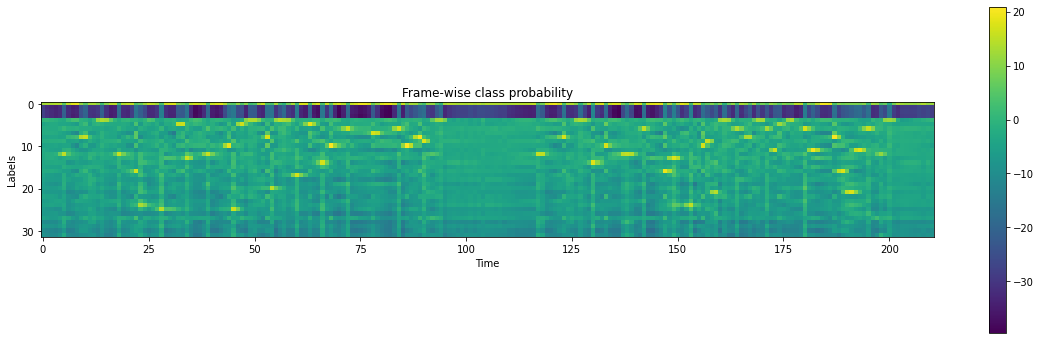

In [265]:
plt.imshow(emission[0].cpu().detach().T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

# Generate alignment probability (trellis)

In [266]:
emission.size()

torch.Size([1, 211, 32])

In [267]:
transcript = ctc_targets_text[utt_id]
tokens = [tokenizer_output_vocab[c] for c in transcript]
print(utt_id, ctc_targets_text[utt_id])
print(list(zip(transcript, tokens)))

def get_trellis(emission, tokens, blank_id=0):
    """
    emission (n_frames, n_output_labels) # NB no b_sz!
    tokens (n_tokens)
    """
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame+1, num_tokens+1), -float('inf')).to(device)
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t+1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis

# NB 
trellis = get_trellis(emission[0], tokens)

LJ007-0048 SO|SUBVERSIVE|OF|MEDITATION|SO|DISTURBING|TO|THE|THOUGHTS
[('S', 12), ('O', 8), ('|', 4), ('S', 12), ('U', 16), ('B', 24), ('V', 25), ('E', 5), ('R', 13), ('S', 12), ('I', 10), ('V', 25), ('E', 5), ('|', 4), ('O', 8), ('F', 20), ('|', 4), ('M', 17), ('E', 5), ('D', 14), ('I', 10), ('T', 6), ('A', 7), ('T', 6), ('I', 10), ('O', 8), ('N', 9), ('|', 4), ('S', 12), ('O', 8), ('|', 4), ('D', 14), ('I', 10), ('S', 12), ('T', 6), ('U', 16), ('R', 13), ('B', 24), ('I', 10), ('N', 9), ('G', 21), ('|', 4), ('T', 6), ('O', 8), ('|', 4), ('T', 6), ('H', 11), ('E', 5), ('|', 4), ('T', 6), ('H', 11), ('O', 8), ('U', 16), ('G', 21), ('H', 11), ('T', 6), ('S', 12)]


### visualise

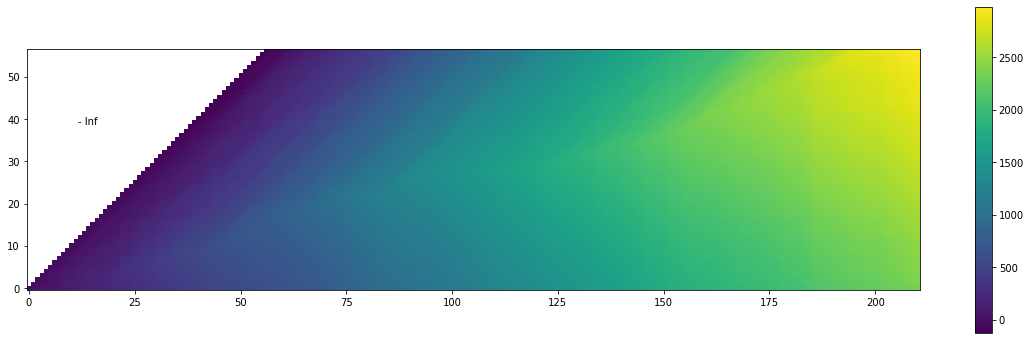

In [268]:
plt.imshow(trellis[1:, 1:].cpu().detach().T, origin='lower')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

# Find the most likely path (backtracking)

In [269]:
@dataclass
class Point:
  token_index: int
  time_index: int
  score: float


def backtrack(trellis, emission, tokens, blank_id=0):
  # Note:
  # j and t are indices for trellis, which has extra dimensions
  # for time and tokens at the beginning.
  # When refering to time frame index `T` in trellis,
  # the corresponding index in emission is `T-1`.
  # Similarly, when refering to token index `J` in trellis,
  # the corresponding index in transcript is `J-1`.
  j = trellis.size(1) - 1
  t_start = torch.argmax(trellis[:, j]).item()

  path = []
  for t in range(t_start, 0, -1):
    # 1. Figure out if the current position was stay or change
    # Note (again):
    # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
    # Score for token staying the same from time frame J-1 to T.
    stayed = trellis[t-1, j] + emission[t-1, blank_id]
    # Score for token changing from C-1 at T-1 to J at T.
    changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

    # 2. Store the path with frame-wise probability.
    prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
    # Return token index and time index in non-trellis coordinate.
    path.append(Point(j-1, t-1, prob))

    # 3. Update the token
    if changed > stayed:
      j -= 1
      if j == 0:
        break
  else:
    raise ValueError('Failed to align')
  return path[::-1]

path = backtrack(trellis, emission[0], tokens)
# print(path)

### visualise

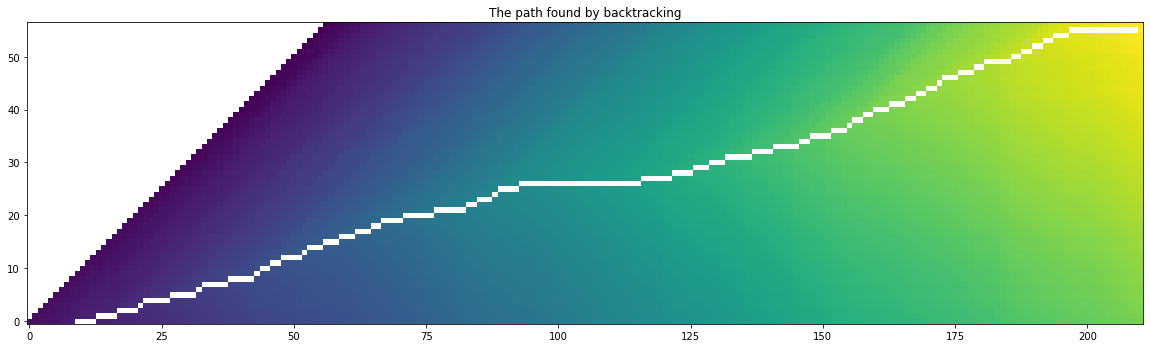

In [270]:
def plot_trellis_with_path(trellis, path):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, p in enumerate(path):
    trellis_with_path[p.time_index, p.token_index] = float('nan')
  plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

plot_trellis_with_path(trellis.cpu().detach(), path)
plt.title("The path found by backtracking")
plt.show()

### merge labels

In [271]:
# Merge the labels
@dataclass
class Segment:
  label: str
  start: int
  end: int
  score: float

  def __repr__(self):
    return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

  @property
  def length(self):
    return self.end - self.start

def merge_repeats(path):
  i1, i2 = 0, 0
  segments = []
  while i1 < len(path):
    while i2 < len(path) and path[i1].token_index == path[i2].token_index:
      i2 += 1
    score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
    segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
    i1 = i2
  return segments

segments = merge_repeats(path)
for seg in segments:
  print(seg)

S	(22343576.39): [    0,    10)
O	(1760790.07): [   10,    14)
|	(1306681.60): [   14,    18)
S	(4015994.41): [   18,    22)
U	(17089072.00): [   22,    23)
B	(2346825.80): [   23,    28)
V	(20209656.20): [   28,    33)
E	(9472558.00): [   33,    34)
R	(6315362.65): [   34,    39)
S	(19743248.85): [   39,    44)
I	(153025488.00): [   44,    45)
V	(5610705.59): [   45,    47)
E	(5435482.39): [   47,    49)
|	(2000295.70): [   49,    53)
O	(34669804.00): [   53,    54)
F	(1409159.57): [   54,    57)
|	(346484.51): [   57,    60)
M	(31381231.33): [   60,    63)
E	(69149254.42): [   63,    66)
D	(19468002.25): [   66,    68)
I	(216617567.78): [   68,    72)
T	(93416037.75): [   72,    78)
A	(66150716.78): [   78,    84)
T	(13569265.50): [   84,    86)
I	(403329648.19): [   86,    89)
O	(528342144.00): [   89,    90)
N	(13193478.06): [   90,    94)
|	(1008531.33): [   94,   117)
S	(56626492.21): [  117,   123)
O	(8339004.13): [  123,   127)
|	(913732.40): [  127,   130)
D	(39491939.83): [  

### visualise trellis with segments and labels

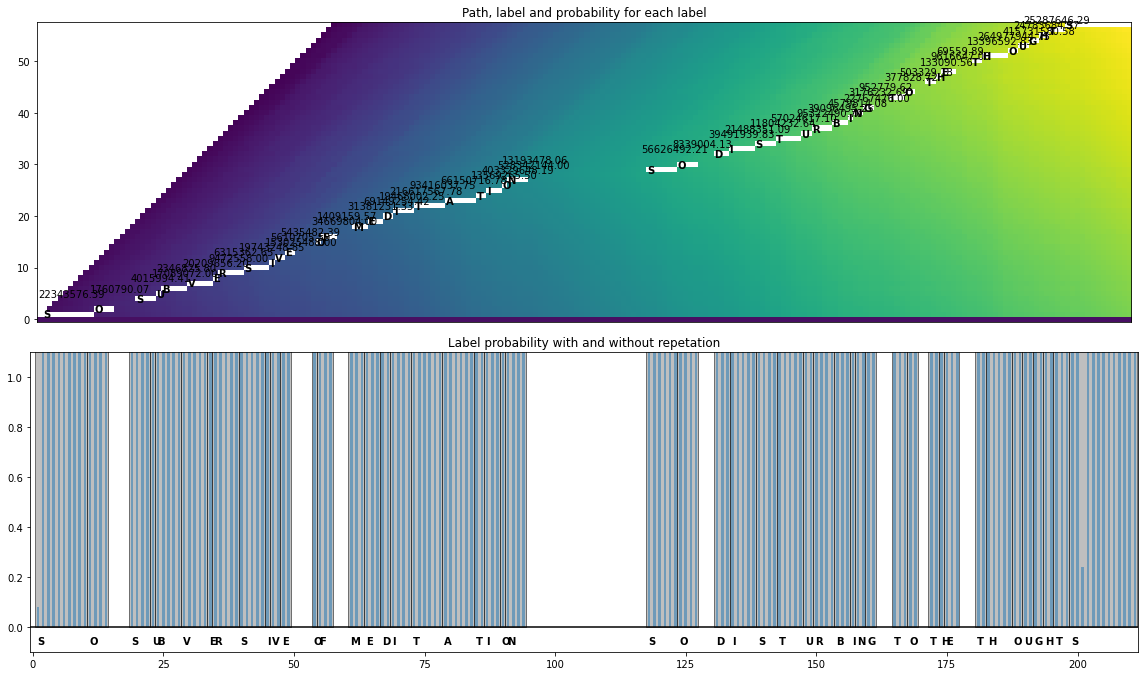

In [272]:
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
  ax1.set_title("Path, label and probability for each label")
  ax1.imshow(trellis_with_path.T, origin='lower')
  ax1.set_xticks([])

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start + .7, i + 0.3), weight='bold')
      ax1.annotate(f'{seg.score:.2f}', (seg.start - .3, i + 4.3))

  ax2.set_title("Label probability with and without repetation")
  xs, hs, ws = [], [], []
  for seg in segments:
    if seg.label != '|':
      xs.append((seg.end + seg.start) / 2 + .4)
      hs.append(seg.score)
      ws.append(seg.end - seg.start)
      ax2.annotate(seg.label, (seg.start + .8, -0.07), weight='bold')
  ax2.bar(xs, hs, width=ws, color='gray', alpha=0.5, edgecolor='black')

  xs, hs = [], []
  for p in path:
    label = transcript[p.token_index]
    if label != '|':
      xs.append(p.time_index + 1)
      hs.append(p.score)

  ax2.bar(xs, hs, width=0.5, alpha=0.5)
  ax2.axhline(0, color='black')
  ax2.set_xlim(ax1.get_xlim())
  ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis.cpu().detach(), segments, transcript)
plt.tight_layout()
plt.show()

In [273]:
# import torch
# from transformers import HubertForCTC, Wav2Vec2Processor
# from datasets import load_dataset
# import soundfile as sf
# import librosa

# processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
# model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft")

# def replace_pad(l, new_symbol='-'):
#     """<pad> refers to epsilon in CTC replace with another symbol for readability"""
#     new_l = []
#     for x in l:
#         if x == "<pad>":
#             new_l.append(new_symbol)
#         else:
#             new_l.append(x)
#     return new_l


# from itertools import groupby


# def reduce_tokens(
#         tokens,
#         pad_symbol="<pad>",
#         word_boundary_symbol="|",
#         remove_epsilons=True,
#         no_repeat_epsilons=False,
#         no_repeat_word_boundaries=False,
#         no_repeat_graphemes=False,
# ):
#     """
#     reduce a sequence of CTC output tokens that contains

#     args:
#         tokens: list of CTC model tokens to reduce
#         remove_epsilons: whether or not to leave epsilons in
#         no_repeat_epsilons: whether to reduce repeated epsilons to just one
#         no_repeat_graphemes: whether to reduce repeated graphemes to just one
#     """
#     reduced_tokens = []
#     all_symbols = []
#     all_durations = []

#     for symbol, group in groupby(tokens):
#         duration = sum(1 for _ in group)
#         all_symbols.append(symbol)
#         all_durations.append(duration)

#         if symbol == pad_symbol:
#             if remove_epsilons:
#                 pass
#             elif no_repeat_epsilons:
#                 reduced_tokens.append(symbol)
#             else:
#                 reduced_tokens.extend(duration * [symbol])
#         elif symbol == word_boundary_symbol:
#             if no_repeat_word_boundaries:
#                 reduced_tokens.append(symbol)
#             else:
#                 reduced_tokens.extend(duration * [symbol])
#         else:
#             if no_repeat_graphemes:
#                 reduced_tokens.append(symbol)
#             else:
#                 reduced_tokens.extend(duration * [symbol])

#     return reduced_tokens, all_symbols, all_durations


# import os
# wav_dir = "/home/s1785140/data/LJSpeech-1.1/wavs"
# wavs = os.listdir(wav_dir)
# wav_paths = [os.path.join(wav_dir, wav) for wav in wavs]

# from tqdm import tqdm

# outdir = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_transcription"
# outdir_with_repeats = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_transcription_with_grapheme_repeats"
# outdir_raw_outputs = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_raw_outputs"

# os.makedirs(outdir, exist_ok=True)
# os.makedirs(outdir_with_repeats, exist_ok=True)
# os.makedirs(outdir_raw_outputs, exist_ok=True)

# print(len(wav_paths))

# all_transcriptions = []
# all_alt_transcriptions = []
# all_raw_outputs = []

# ljspeech_sampling_rate = 22050
# hubert_sampling_rate = 16000

# for i, wav_path in enumerate(tqdm(wav_paths[:])):
#     speech, _ = sf.read(wav_path)
#     speech = librosa.resample(speech, ljspeech_sampling_rate, hubert_sampling_rate)
#     utt_id = wav_path.split('/')[-1].split('.')[0]
#     input_values = processor(speech, return_tensors="pt").input_values
#     logits = model(input_values).logits
#     predicted_ids = torch.argmax(logits, dim=-1)
#     transcription = processor.decode(predicted_ids[0])

#     filtered_tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids[0].tolist(), skip_special_tokens=False)
#     reduced_tokens, all_symbols, all_durations = reduce_tokens(
#         filtered_tokens,
#         remove_epsilons=True,
#         no_repeat_epsilons=False,
#         no_repeat_word_boundaries=True,
#         no_repeat_graphemes=False
#     )
#     alt_transcription = replace_pad(reduced_tokens)
#     alt_transcription = [sym if sym != "|" else " " for sym in alt_transcription]
#     alt_transcription = "".join(alt_transcription)

#     raw_outputs = replace_pad(filtered_tokens)
#     raw_outputs = [sym if sym != "|" else " " for sym in raw_outputs]
#     raw_outputs = "".join(raw_outputs)

#     print(i, '===', raw_outputs)
#     print(i, '===', transcription)
#     print(i, '===', alt_transcription)

#     all_transcriptions.append(f"{utt_id}||{transcription.lower()}")
#     all_alt_transcriptions.append(f"{utt_id}||{alt_transcription.lower()}")
#     all_raw_outputs.append(f"{utt_id}||{raw_outputs.lower()}")

#     outfile = f"{utt_id}.txt"

#     # save proper transcription
#     with open(os.path.join(outdir, outfile), 'w') as f:
#         f.write(all_transcriptions[-1])

#     # save alternative transcription
#     with open(os.path.join(outdir_with_repeats, outfile), 'w') as f:
#         f.write(all_alt_transcriptions[-1])

#     # save raw outputs
#     with open(os.path.join(outdir_raw_outputs, outfile), 'w') as f:
#         f.write(all_raw_outputs[-1])

# outfile = f"metadata.csv"

# all_transcriptions = sorted(all_transcriptions)
# all_alt_transcriptions = sorted(all_alt_transcriptions)
# all_raw_outputs = sorted(all_raw_outputs)

# print(all_transcriptions)
# print(all_alt_transcriptions)
# print(all_raw_outputs)

# # save proper transcription
# with open(os.path.join(outdir, outfile), 'w') as f:
#     f.write("\n".join(all_transcriptions))

# # save alternative transcription
# with open(os.path.join(outdir_with_repeats, outfile), 'w') as f:
#     f.write("\n".join(all_alt_transcriptions))

# # save raw outputs
# with open(os.path.join(outdir_raw_outputs, outfile), 'w') as f:
#     f.write("\n".join(all_raw_outputs))
